# Classification of Citrus Leaves with ResNet50
Data is downloaded from [this site](https://data.mendeley.com/datasets/3f83gxmv57/2).

## Create Dataloader
A custom dataset and dataloader can be created from [these instructions](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
).

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
encoder = {
    "healthy" : 0,
    "black_spot" : 1,
    "canker" : 2,
    "greening" : 3,
    "healthy" : 4,
    "melanose" : 5
}

# class label is name of sub directory, images are in sub directory
class CitrusLeavesDataset(Dataset):
    def __init__(self, img_dir, transform = None, target_transform = None):
        # define main directory of images and transformations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # store paths and labels in DataFrame
        data = { "image_path" : [], "label" : [] }
        for sub_dir in os.listdir(img_dir):
            for file in os.listdir(os.path.join(img_dir, sub_dir)):
                data['image_path'].append(os.path.join(img_dir, sub_dir, file))
                data['label'].append(sub_dir)

        # store in annotations
        self.annotations = pd.DataFrame(data)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image path and label
        image = read_image(self.annotations.iloc[idx, 0]).float()
        label = encoder[self.annotations.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [3]:
TRAIN_PROPORTION = 0.8
BATCH_SIZE = 32
EPOCHS = 40
SIZE = (256, 256)
RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]
LEARNING_RATE = 0.001

In [4]:
# load data
transform = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.Normalize(mean = RESNET_MEAN, std = RESNET_STD)
])
citrus_leaves_dataset = CitrusLeavesDataset(img_dir = "./data_citrus_leaves/", transform = transform)

# get train size and test size
train_size = int(TRAIN_PROPORTION * len(citrus_leaves_dataset))
test_size = len(citrus_leaves_dataset) - train_size

# split data
train_dataset, test_dataset = torch.utils.data.random_split(citrus_leaves_dataset, [train_size, test_size])

# create data loaders
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# get information on dataset
class_names = citrus_leaves_dataset.annotations['label'].unique()
print("Classes:", class_names)
print("Dataset length:", len(citrus_leaves_dataset))

Classes: ['black_spot' 'canker' 'greening' 'healthy' 'melanose']
Dataset length: 609


The dataset contains $609$ images of healthy and unhealthy leaves. The images are in PNG format and have size $256\times256$.

There are five classes: `black_spot`, `canker`, `greening`, `healthy`, and `melanose`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


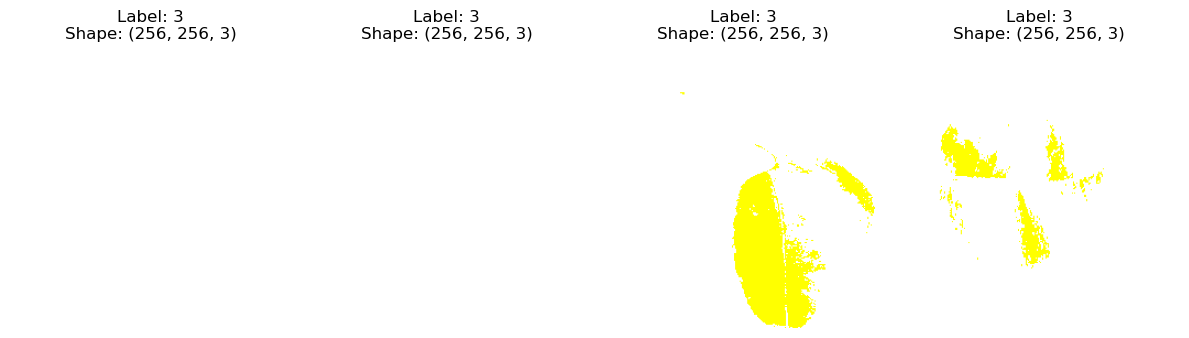

In [7]:
# show random sample images
fig, axes = plt.subplots(1, 4, figsize = (12, 5))
for i in range(4):
    image, label = citrus_leaves_dataset[np.random.randint(0, len(citrus_leaves_dataset))]
    image = image.numpy().transpose(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title("Label: {}\nShape: {}".format(label, image.shape))
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [8]:
# load ResNet50 model
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained = True)

Using cache found in C:\Users\fongc/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# create feature extraction model
feature_extraction = nn.Sequential(*list(model.children())[:-1])
sample = feature_extraction(torch.rand(1, 3, SIZE[0], SIZE[1]))
print("Shape of feature extraction part:", sample.shape)

# freeze parameters
for param in feature_extraction.parameters():
    param.requires_grad = False

Shape of feature extraction part: torch.Size([1, 2048, 1, 1])


In [10]:
# create classifier
model = nn.Sequential(
    feature_extraction,
    nn.Flatten(),
    nn.Linear(2048, 6),
).to(device)

In [11]:
# define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [12]:
# train model
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

In [49]:
# make predictions
predictions = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.float()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

tensor([1, 1, 2, 2, 2, 3, 1, 3, 2, 1, 2, 2, 1, 3, 1, 2, 1, 1, 1, 1, 3, 1, 4, 3,
        2, 2, 3, 1, 2, 4, 3, 5], device='cuda:0')
tensor([2, 1, 3, 3, 1, 1, 3, 1, 3, 1, 2, 3, 2, 3, 2, 1, 2, 2, 1, 3, 2, 4, 1, 1,
        1, 2, 2, 4, 2, 4, 1, 1], device='cuda:0')
tensor([2, 2, 1, 1, 3, 2, 1, 2, 1, 3, 3, 3, 2, 3, 3, 3, 2, 4, 4, 3, 2, 3, 3, 2,
        3, 3, 1, 5, 3, 1, 3, 1], device='cuda:0')
tensor([1, 3, 1, 3, 3, 2, 1, 2, 1, 3, 3, 4, 3, 3, 3, 1, 3, 1, 2, 2, 1, 3, 1, 3,
        1, 3], device='cuda:0')


In [15]:
print("Accuracy:", correct / total)

Accuracy: 0.9508196721311475


In [29]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

inv_tensor = invTrans(images)

4
4


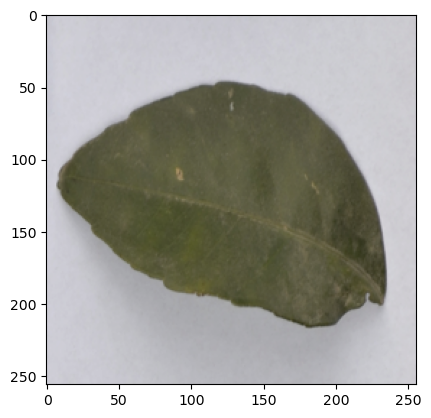

In [45]:
prediction = model(images)
_, predicted = torch.max(prediction.data, 1)
print(predicted[4].item())
print(labels[4].item())

plt.imshow(inv_tensor.detach().cpu().numpy()[4, :, :].astype(np.int32).transpose(1, 2, 0))

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(labels, prediction[:, 1])

In [47]:
for sub_dir in os.listdir("./data_citrus_leaves/"):
    print(len(os.listdir("./data_citrus_leaves/" + sub_dir)))

171
163
204
58
13
